We follow the a part of the tutorial in unit FIT3181, week 5: "Attack and Defence Deep Learning Models"

Deep learning models, even the SOTA ones, are fragile and easy to be attacked by adversarial examples. This tutorial focuses on how to run attacks to fool deep learning models and how to train more secure and safe deep learning models using adversarial training.

**References and additional reading and resources**
- [Adversarial machine learning tutorial](https://adversarial-ml-tutorial.org/introduction/)
- [Adversarial example using FGSM tutorial](https://www.tensorflow.org/tutorials/generative/adversarial_fgsm)
---


## <span style="color:#0b486b">I. Attack functions </span> ##

We begin with manually implementing the popular adversarial attacks including FGSM, PGD, MIM, and TRADES ones. Those attacks have also been implemented in [CleverHans](https://github.com/cleverhans-lab/cleverhans), a library for adversarial machine learning in which many adversarial attacks are implemented. Subsequently, we can use those adversarial examples crafted from those attacks to strengthen the adversarial robustness of DL models for obtaining more robust and secure DL models.

In [1]:
import tensorflow as tf

We first implement Fast Gradient Sign Method (FGSM) in this paper: https://arxiv.org/pdf/1412.6572.pdf.

In [2]:
def fgsm_attack(model, input_image, input_label=None,
               epsilon=0.3,
               clip_value_min=0.,
               clip_value_max=1.0,
               soft_label=False,
               from_logits=True):
    """
    Args:
        model: pretrained model
        input_image: original (clean) input image (tensor)
        input_label: original label (tensor, categorical representation)
        epsilon: perturbation boundary
        clip_value_min, clip_value_max: range of valid input
        from_logits = True: attack from logits otherwise attack from prediction probabilites
    Note:
        we expect the output of model should be logits vector
    """

    loss_fn = tf.keras.losses.sparse_categorical_crossentropy # compute CE loss from logits or prediction probabilities

    if type(input_image) is np.ndarray:
        input_image = tf.convert_to_tensor(input_image)

    if type(input_label) is np.ndarray:
        input_label = tf.convert_to_tensor(input_label)

    with tf.GradientTape() as tape:
        tape.watch(input_image)
        output = model(input_image)
        if not soft_label:
            loss = loss_fn(input_label, output, from_logits=from_logits) # use ground-truth label to attack
        else:
            pred_label = tf.math.argmax(output, axis=1) # use predicted label to attack
            loss = loss_fn(pred_label, output, from_logits=from_logits)

    gradient = tape.gradient(loss, input_image) # get the gradients of the loss w.r.t. the input image
    adv_image = input_image + epsilon * tf.sign(gradient) # get the final adversarial examples
    adv_image = tf.clip_by_value(adv_image, clip_value_min, clip_value_max) # clip to a valid range
    adv_image = tf.stop_gradient(adv_image) # stop the gradient to make the adversarial image as a constant input
    return adv_image

Next, we implement Projected Gradient Descend (PGD) proposed in this paper: https://openreview.net/pdf?id=rJzIBfZAb. PGD can be viewed as an extended version of FGSM in which the attack is done in many iterations.

In [3]:
def pgd_attack(model, input_image, input_label= None,
              epsilon=0.3,
              num_steps=20,
              step_size=0.01,
              clip_value_min=0.,
              clip_value_max=1.0,
              soft_label=False,
              from_logits= True):
    """
    Args:
        model: pretrained model
        input_image: original (clean) input image (tensor)
        input_label: original label (tensor, categorical representation)
        epsilon: perturbation boundary
        num_steps: number of attack steps
        step_size: size of each move in each attack step
        clip_value_min, clip_value_max: range of valid input
        from_logits = True: attack from logits otherwise attack from prediction probabilites
    Note:
        we expect the output of model should be logits vector
    """

    loss_fn = tf.keras.losses.sparse_categorical_crossentropy  #compute CE loss from logits or prediction probabilities

    if type(input_image) is np.ndarray:
        input_image = tf.convert_to_tensor(input_image)

    if type(input_label) is np.ndarray:
        input_label = tf.convert_to_tensor(input_label)

    # random initialization around input_image
    random_noise = tf.random.uniform(shape=input_image.shape, minval=-epsilon, maxval=epsilon)
    adv_image = input_image + random_noise

    for _ in range(num_steps):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(adv_image)
            adv_output = model(adv_image)
            if not soft_label:
                loss = loss_fn(input_label, adv_output, from_logits= from_logits) # use ground-truth label to attack
            else:
                pred_label = tf.math.argmax(adv_output, axis=1)
                loss = loss_fn(pred_label, adv_output, from_logits= from_logits) # use predicted label to attack

        gradient = tape.gradient(loss, adv_image) # get the gradient of the loss w.r.t. the current point
        adv_image = adv_image + step_size * tf.sign(gradient) # move current adverarial example along the gradient direction with step size is eta
        adv_image = tf.clip_by_value(adv_image, input_image-epsilon, input_image+epsilon) # clip to a valid boundary
        adv_image = tf.clip_by_value(adv_image, clip_value_min, clip_value_max)  # clip to a valid range
        adv_image = tf.stop_gradient(adv_image) # stop the gradient to make the adversarial image as a constant input
    return adv_image

We now implement Momentum Iterative Method (MIM) proposed in this paper: https://openaccess.thecvf.com/content_cvpr_2018/papers/Dong_Boosting_Adversarial_Attacks_CVPR_2018_paper.pdf. MIM uses a momentum approach to boost the adversarial examples.

In [4]:
def mim_attack(model, input_image, input_label= None,
              epsilon=0.3,
              gamma= 0.9,
              num_steps=20,
              step_size=0.01,
              clip_value_min=0.,
              clip_value_max=1.0,
              soft_label=False,
              from_logits= True):
    """
    Args:
        model: pretrained model
        input_image: original (clean) input image (tensor)
        input_label: original label (tensor, categorical representation)
        epsilon: perturbation boundary
        gamma: momentum decay
        num_steps: number of attack steps
        step_size: size of each move in each attack step
        clip_value_min, clip_value_max: range of valid input
        from_logits = True: attack from logits otherwise attack from prediction probabilites
    Note:
        we expect the output of model should be logits vector
    """

    loss_fn = tf.keras.losses.sparse_categorical_crossentropy # compute CE loss from logits or prediction probabilities

    if type(input_image) is np.ndarray:
        input_image = tf.convert_to_tensor(input_image)

    if type(input_label) is np.ndarray:
        input_label = tf.convert_to_tensor(input_label)

    # random initialization around input_image
    random_noise = tf.random.uniform(shape=input_image.shape, minval=-epsilon, maxval=epsilon)
    adv_image = input_image + random_noise
    adv_noise = random_noise

    for _ in range(num_steps):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(adv_image)
            adv_output = model(adv_image)
            if not soft_label:
                loss = loss_fn(input_label, adv_output, from_logits=from_logits) # use ground-truth label to attack
            else:
                pred_label = tf.math.argmax(adv_output, axis=1)
                loss = loss_fn(pred_label, adv_output, from_logits=from_logits) # use predicted label to attack

        gradient = tape.gradient(loss, adv_image) # get the gradient of the loss w.r.t. the current point
        adv_image_new = adv_image + step_size * tf.sign(gradient) # move current adverarial example along the gradient direction with step size is eta
        adv_image_new = tf.clip_by_value(adv_image_new, input_image-epsilon, input_image+epsilon) # clip to a valid boundary
        adv_image_new = tf.clip_by_value(adv_image_new, clip_value_min, clip_value_max) # clip to a valid range
        adv_noise = gamma*adv_noise + (1-gamma)*(adv_image_new - adv_image)
        adv_image = adv_image_new
        adv_image = tf.stop_gradient(adv_image) # stop the gradient to make the adversarial image as a constant input
    adv_image = adv_image + adv_noise
    adv_image = tf.clip_by_value(adv_image, input_image-epsilon, input_image+epsilon) # clip to a valid boundary
    adv_image = tf.clip_by_value(adv_image, clip_value_min, clip_value_max) # clip to a valid range
    return adv_image

Finally, we implement one of the most famous approaches for attack and defence TRADES proposed in this paper: http://proceedings.mlr.press/v97/zhang19p/zhang19p.pdf.

In [5]:
def trades_attack(model, input_image, input_label,
                 epsilon=0.3,
                  num_steps=20,
                  step_size=0.01,
                  clip_value_min=0.,
                  clip_value_max=1.0,
                  from_logits= False):
    """
    Args:
        model: pretrained model
        input_image: original (clean) input image (tensor)
        input_label: original label (tensor, categorical representation)
        epsilon: perturbation boundary
        num_steps: number of attack steps
        step_size: size of each move in each attack step
        clip_value_min, clip_value_max: range of valid input
        from_logits = True: attack from logits otherwise attack from prediction probabilites
    Note:
        we expect the output of model should be logits vector
    """

    if type(input_image) is np.ndarray:
        input_image = tf.convert_to_tensor(input_image)
    if type(input_label) is np.ndarray:
        input_label = tf.convert_to_tensor(input_label)

    # random initialization around input_image
    random_noise = tf.random.uniform(shape=input_image.shape, minval=-epsilon, maxval=epsilon)
    adv_image = input_image + random_noise

    nat_output = model(input_image)
    nat_prediction = nat_output if not from_logits else tf.math.softmax(nat_output, axis=1)

    for _ in range(num_steps):
        with tf.GradientTape() as tape:
            tape.watch(adv_image)
            adv_output = model(adv_image)
            adv_prediction = adv_output if not from_logits else tf.math.softmax(adv_output, axis=1)
            loss = tf.keras.losses.KLDivergence()(adv_prediction,  nat_prediction)
        gradient = tape.gradient(loss, adv_image) # get the gradient of the loss w.r.t. the current point
        adv_image = adv_image + step_size * tf.sign(gradient) # move current adverarial example along the gradient direction with step size is eta
        adv_image = tf.clip_by_value(adv_image, input_image-epsilon, input_image+epsilon) # clip to a valid boundary
        adv_image = tf.clip_by_value(adv_image, clip_value_min, clip_value_max) # clip to a valid range
        adv_image = tf.stop_gradient(adv_image)  # stop the gradient to make the adversarial image as a constant input
    return adv_image

## <span style="color:#0b486b">II. Attacking SOTA pretrained models</span> ##

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, models, layers
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.applications import VGG19
import math
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
import numpy as np

The following snippet shows you how to load the VGG19 model pre-trained on ImageNet.

In [9]:
print("Loading network...")
vgg19 = VGG19(weights="imagenet", include_top=True, input_tensor=layers.Input(shape=(224,224,3)))
# print("Showing layers...")
# # loop over the layers in the network and display them to the console
# for (i, layer) in enumerate(vgg19.layers):
#     print("{}\t{}\t{}".format(i, layer.__class__.__name__, layer.name))

Loading network...


In [8]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Let's take an image and evaluate the model prediction on this image.

In [10]:
!gdown https://drive.google.com/uc?id=1NutSZDuSM0ol3v4crS2RsvuqIKgoUpkr -O images.zip
!unzip -q ./images.zip
!rm ./images.zip

Downloading...
From: https://drive.google.com/uc?id=1NutSZDuSM0ol3v4crS2RsvuqIKgoUpkr
To: /content/images.zip
100% 225k/225k [00:00<00:00, 45.6MB/s]


1/1 [==============================] - 1s 772ms/step
Predicted: [('n02504458', 'African_elephant', 0.4604727), ('n02504013', 'Indian_elephant', 0.30082467), ('n01871265', 'tusker', 0.23512723)]


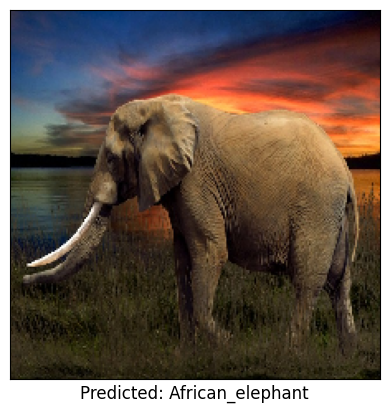

In [30]:
img_path = './images/elephant.jpg'

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

preds = vgg19.predict(x)

# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])
plt.imshow(img)
plt.xlabel("Predicted: {}".format(decode_predictions(preds, top=3)[0][0][1]), fontsize= 12)
plt.xticks([])
plt.yticks([])
plt.grid(False)

### Practive with untargeted attacks
The VGG19 model predicts correctly this image of an elephant. Now let's see how it performs on the adversarial image generated from PGD attack.

In [31]:
# soft_label=True so we do not need to provide input label
x_pgd= pgd_attack(vgg19, x, None, epsilon=8, num_steps=20,  step_size= 0.1, soft_label=True, clip_value_min=0.0, clip_value_max=255.0, from_logits=False)
pgd_pred = vgg19.predict(x_pgd)
true_label= decode_predictions(preds, top=3)[0][0][1]
adv_label= decode_predictions(pgd_pred, top=3)[0][0][1]
print("Prediction before adversarial attack: {} - {:.3f}".format(true_label, preds.max()))
print("Prediction after adversarial attack: {} - {:.3f}".format(adv_label, pgd_pred.max()))

1/1 [==============================] - 1s 622ms/step
Prediction before adversarial attack: African_elephant - 0.460
Prediction after adversarial attack: Indian_elephant - 0.383


It is seen that the model predicts the image incorrectly, although, as revealed below, the adversarial image looks identical to the original one from the human perspective.

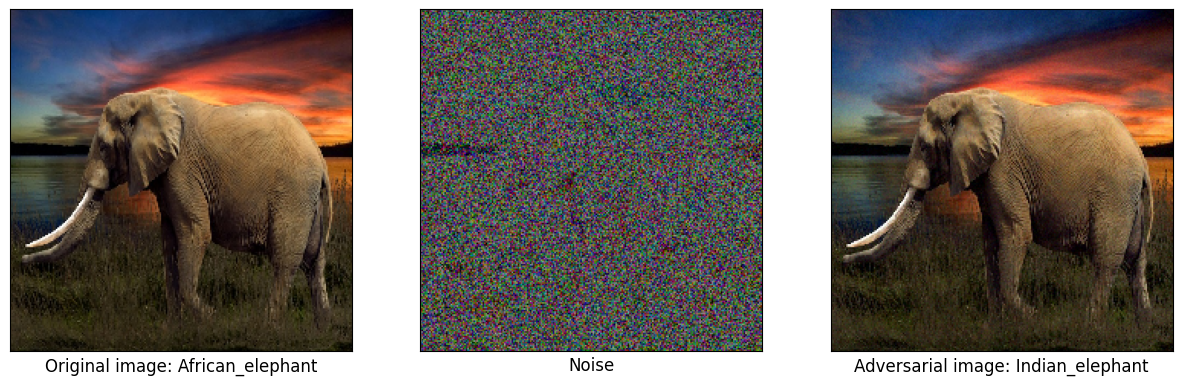

In [32]:
img_pgd = np.squeeze(x_pgd.numpy()).astype('int')
img = np.squeeze(x).astype('int')
noise_pgd = np.clip(np.abs(img_pgd - img)*20, 0, 255).astype('int') # we multiply the noise by 20 for visualization
fig = plt.figure(figsize=(15, 15*3))
for i in range(3):
    shown_img = img if i==0 else noise_pgd if i==1 else img_pgd
    shown_label = 'Original image: {}'.format(true_label) if i==0 else 'Noise' if i==1 else 'Adversarial image: {}'.format(adv_label)
    plt.subplot(1,3,i+1)
    plt.imshow(shown_img)
    plt.xlabel(shown_label, fontsize= 12)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

In [33]:
x_fgsm = fgsm_attack(vgg19, x, None, epsilon=8, soft_label=True, clip_value_min=0.0, clip_value_max=255.0, from_logits=False)
fgsm_pred = vgg19.predict(x_fgsm)
true_label= decode_predictions(preds, top=3)[0][0][1]
adv_label= decode_predictions(fgsm_pred, top=3)[0][0][1]
print("Prediction before adversarial attack by FGSM: {} - {:.3f}".format(true_label, preds.max()))
print("Prediction after adversarial attack by FGSM: {} - {:.3f}".format(adv_label, fgsm_pred.max()))

1/1 [==============================] - 1s 1s/step
Prediction before adversarial attack by FGSM: African_elephant - 0.460
Prediction after adversarial attack by FGSM: Indian_elephant - 0.465


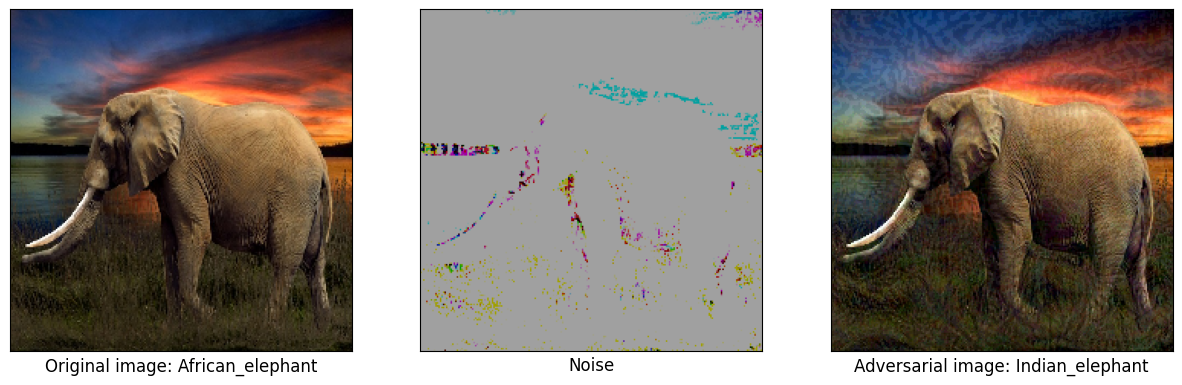

In [35]:
img_fgsm = np.squeeze(x_fgsm.numpy()).astype('int')
img = np.squeeze(x).astype('int')
noise_fgsm = np.clip(np.abs(img_fgsm - img)*20, 0, 255).astype('int') # we multiply the noise by 20 for visualization
fig = plt.figure(figsize=(15, 15*3))
for i in range(3):
    shown_img = img if i==0 else noise_fgsm if i==1 else img_fgsm
    shown_label = 'Original image: {}'.format(true_label) if i==0 else 'Noise' if i==1 else 'Adversarial image: {}'.format(adv_label)
    plt.subplot(1,3,i+1)
    plt.imshow(shown_img)
    plt.xlabel(shown_label, fontsize= 12)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

In [36]:
x_mim = mim_attack(vgg19, x, None, epsilon=8, num_steps=20, step_size=0.1, soft_label=True, clip_value_min=0.0, clip_value_max=255.0, from_logits=False)
mim_pred = vgg19.predict(x_mim)
# true_label= decode_predictions(preds, top=3)[0][0][1]
adv_label= decode_predictions(mim_pred, top=3)[0][0][1]
print("Prediction before adversarial attack by MIM: {} - {:.3f}".format(true_label, preds.max()))
print("Prediction after adversarial attack by MIM: {} - {:.3f}".format(adv_label, mim_pred.max()))

1/1 [==============================] - 1s 744ms/step
Prediction before adversarial attack by MIM: African_elephant - 0.460
Prediction after adversarial attack by MIM: Indian_elephant - 0.313


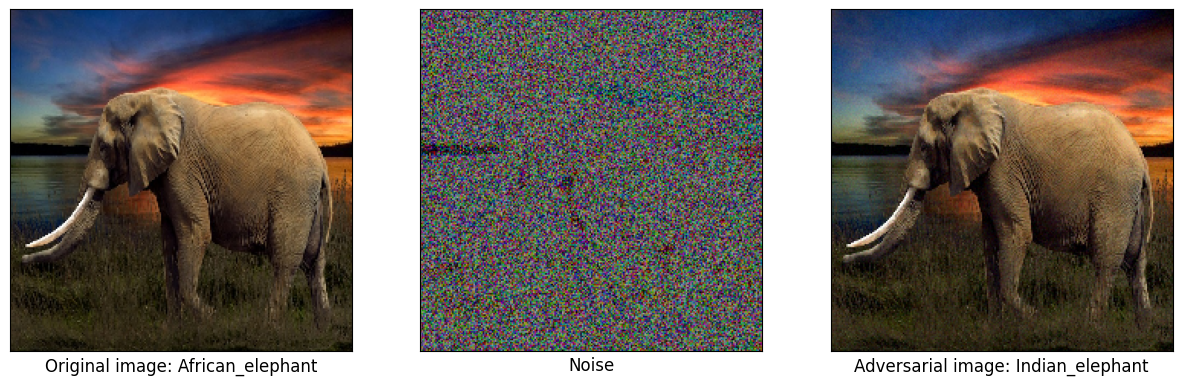

In [37]:
img_mim = np.squeeze(x_mim.numpy()).astype('int')
img = np.squeeze(x).astype('int')
noise_mim = np.clip(np.abs(img_mim - img)*20, 0, 255).astype('int') # we multiply the noise by 20 for visualization
fig = plt.figure(figsize=(15, 15*3))
for i in range(3):
    shown_img = img if i==0 else noise_mim if i==1 else img_mim
    shown_label = 'Original image: {}'.format(true_label) if i==0 else 'Noise' if i==1 else 'Adversarial image: {}'.format(adv_label)
    plt.subplot(1,3,i+1)
    plt.imshow(shown_img)
    plt.xlabel(shown_label, fontsize= 12)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

### Practive with targeted attacks

In [45]:
# Practice with targeted attack on PDG
# Attack model with label eel (index 390) from original clean sample
x_pgd = pgd_attack(vgg19, x, input_label=np.array([390]), epsilon=8, num_steps=20,  step_size=-0.1, clip_value_min=0.0, clip_value_max=255.0, from_logits=False)
pgd_pred = vgg19.predict(x_pgd)
true_label= decode_predictions(preds, top=3)[0][0][1]
adv_label= decode_predictions(pgd_pred, top=3)[0][0][1]
print("Prediction before adversarial attack: {} - {:.3f}".format(true_label, preds.max()))
print("Prediction after adversarial attack: {} - {:.3f}".format(adv_label, pgd_pred.max()))

1/1 [==============================] - 1s 646ms/step
Prediction before adversarial attack: African_elephant - 0.460
Prediction after adversarial attack: eel - 0.996


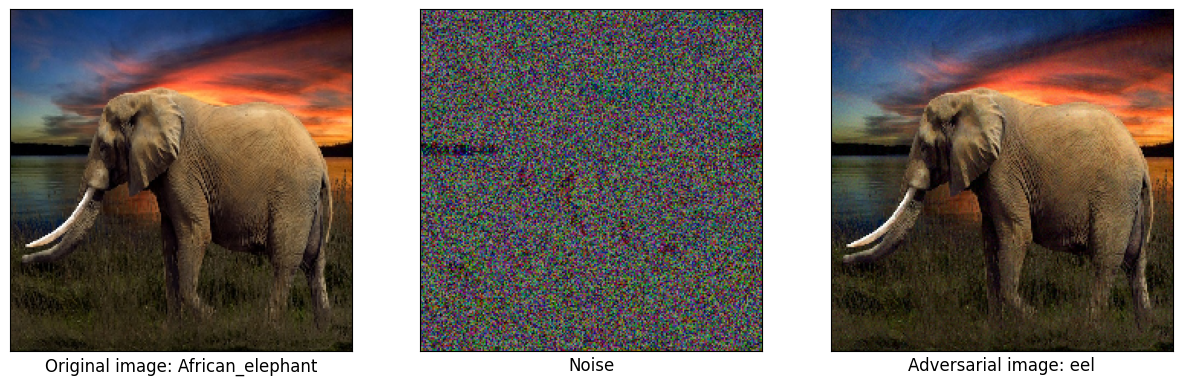

In [46]:
img_pgd = np.squeeze(x_pgd.numpy()).astype('int')
img = np.squeeze(x).astype('int')
noise_pgd = np.clip(np.abs(img_pgd - img)*20, 0, 255).astype('int') # we multiply the noise by 20 for visualization
fig = plt.figure(figsize=(15, 15*3))
for i in range(3):
    shown_img = img if i==0 else noise_pgd if i==1 else img_pgd
    shown_label = 'Original image: {}'.format(true_label) if i==0 else 'Noise' if i==1 else 'Adversarial image: {}'.format(adv_label)
    plt.subplot(1,3,i+1)
    plt.imshow(shown_img)
    plt.xlabel(shown_label, fontsize= 12)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

In [47]:
# label index 123 is "spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish"
x_mim = mim_attack(vgg19, x, input_label=np.array([123]), epsilon=8, num_steps=20, step_size=-0.1, clip_value_min=0.0, clip_value_max=255.0, from_logits=False)
mim_pred = vgg19.predict(x_mim)
# true_label= decode_predictions(preds, top=3)[0][0][1]
adv_label= decode_predictions(mim_pred, top=3)[0][0][1]
print("Prediction before adversarial attack by MIM: {} - {:.3f}".format(true_label, preds.max()))
print("Prediction after adversarial attack by MIM: {} - {:.3f}".format(adv_label, mim_pred.max()))

1/1 [==============================] - 1s 631ms/step
Prediction before adversarial attack by MIM: African_elephant - 0.460
Prediction after adversarial attack by MIM: spiny_lobster - 0.952


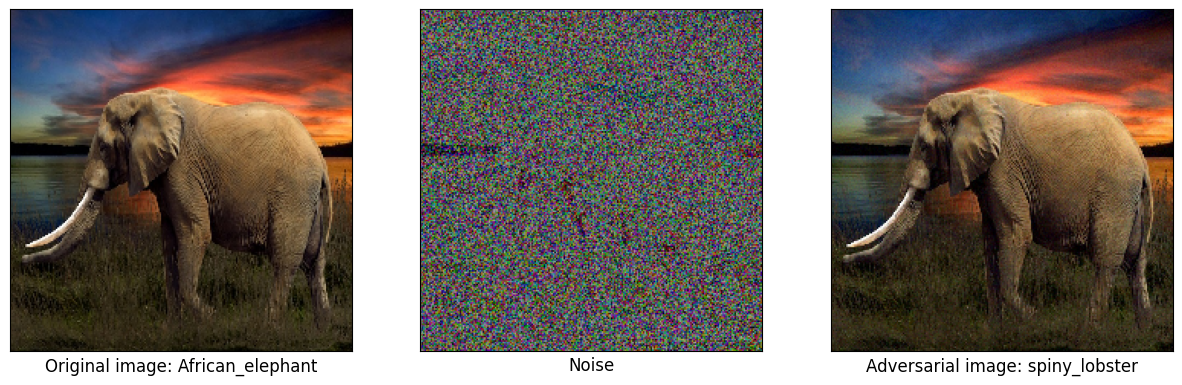

In [49]:
img_mim = np.squeeze(x_mim.numpy()).astype('int')
img = np.squeeze(x).astype('int')
noise_mim = np.clip(np.abs(img_mim - img)*20, 0, 255).astype('int') # we multiply the noise by 20 for visualization
fig = plt.figure(figsize=(15, 15*3))
for i in range(3):
    shown_img = img if i==0 else noise_mim if i==1 else img_mim
    shown_label = 'Original image: {}'.format(true_label) if i==0 else 'Noise' if i==1 else 'Adversarial image: {}'.format(adv_label)
    plt.subplot(1,3,i+1)
    plt.imshow(shown_img)
    plt.xlabel(shown_label, fontsize= 12)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)